###Formulas for counting number of maps that are consistent with a set of colorings.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import comb
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk
from imagery_psychophysics.src import counting_machinery as cntmch
from math import factorial as bang

Populating the interactive namespace from numpy and matplotlib


####counting object maps made by concatenating many smaller sub-maps
I'm not sure if this is even useful...

In [2]:
def count_object_maps(num_objects, sub_map_sizes, scaling_term=1.):
    e_comb = lambda n,k: comb(n,k,exact=True)
    return np.sum([e_comb(num_objects,k)*(-1)**k*np.prod([np.sum([e_comb(num_objects-k,j)*snk(scaling_term*sms,j)*bang(j) for j in range(1,num_objects-k+1)]) for sms in sub_map_sizes]) for k in range(0,num_objects)])

...but it is apparently true! (Although, note overflow problems for really large cases).

In [123]:
n = 4
sub_map_sizes = np.random.randint(1,5,size=15)
scale = 1 
print 'number_of_pixels: %d ' %(np.sum(sub_map_sizes))
print '%d' %(count_object_maps(n,sub_map_sizes,scaling_term=scale))
print '%d' %(snk(scale*np.sum(sub_map_sizes),n)*bang(n))

number_of_pixels: 39 
302215244686343744258048
2236526760168529920


An illustration of why we need this -- you can't just sum of bits of the map to get the total. You grossly undercount.

In [4]:
number_of_objects_in_map = 2
number_of_pixels_in_submap_1 = 10
number_of_pixels_in_submap_2 = 10
total_number_of_map_pixels = number_of_pixels_in_submap_1 + number_of_pixels_in_submap_2
print 'total number of object maps: %d' %(snk(total_number_of_map_pixels,number_of_objects_in_map)*bang(number_of_objects_in_map))
print 'sum of number of submaps: %d' %((snk(number_of_pixels_in_submap_1,number_of_objects_in_map)+snk(number_of_pixels_in_submap_2,number_of_objects_in_map))*bang(number_of_objects_in_map))
print 'prod of number of submaps: %d' %(snk(number_of_pixels_in_submap_1,number_of_objects_in_map)*snk(number_of_pixels_in_submap_2,number_of_objects_in_map)*bang(number_of_objects_in_map))**2
print 'total number of maps using correct sum over submaps: %d' %(count_object_maps(number_of_objects_in_map, [number_of_pixels_in_submap_1,number_of_pixels_in_submap_2]))
print 'See?'

total number of object maps: 1048574
sum of number of submaps: 2044
prod of number of submaps: 272736706564
total number of maps using correct sum over submaps: 1048574
See?


####If we observe counts in a bunch of non-overlapping windows, how many map are consistent with the observations?

Counts maps consistent with data

In [5]:
def maps_consistent_with_data(number_of_objects, sub_map_sizes, submap_color_counts,scaling_term=1.0):
    e_comb = lambda n,j: comb(n,j,exact=True)
    cnt = np.sum(
        [e_comb(number_of_objects,k)*(-1)**k
                 *np.prod([e_comb(number_of_objects-k,scc)*snk(scaling_term*sms,scc)*bang(scc)
                           for scc,sms in zip(submap_color_counts,sub_map_sizes)]) for k in range(0,number_of_objects)])
    return cnt

Set up map, windows, sizes

In [125]:
number_of_objects_in_map = 5
largest_number_of_windows = 6
total_number_of_pixels = 2**largest_number_of_windows
number_of_windows = np.cumprod([1]+[2]*(largest_number_of_windows))
samples_per_window_size = 1000
print 'number of pixels: %d' %(total_number_of_pixels)
print number_of_windows


number of pixels: 64
[ 1  2  4  8 16 32 64]


Loop over number of windows, generating random samples of color counts. Get average number of consistent
maps for 

In [126]:
cm_mean = np.zeros((len(number_of_windows),1))
cm_max = np.zeros((len(number_of_windows),1))
cm_min = np.zeros((len(number_of_windows),1))
cnt = 0
for nw in number_of_windows:
    size_of_windows = total_number_of_pixels/nw
    print 'size of windows %f' %(size_of_windows)
    cm = np.zeros((samples_per_window_size,1))
    for spw in range(samples_per_window_size):
        if nw==1:
            color_counts = number_of_objects_in_map*np.ones((nw,1))
        else:
            color_counts = np.random.random_integers(1,high=min(size_of_windows,number_of_objects_in_map),size=(nw,1))
        cm[spw] = maps_consistent_with_data(number_of_objects_in_map,size_of_windows*np.ones((nw,1)),color_counts)
    cm_mean[cnt] = cm.mean()
    cm_max[cnt] = cm.max()
    cm_min[cnt] = cm.min()
    cnt += 1
total_maps = snk(total_number_of_pixels, number_of_objects_in_map)*bang(number_of_objects_in_map)

size of windows 64.000000
size of windows 32.000000
size of windows 16.000000
size of windows 8.000000
size of windows 4.000000
size of windows 2.000000
size of windows 1.000000


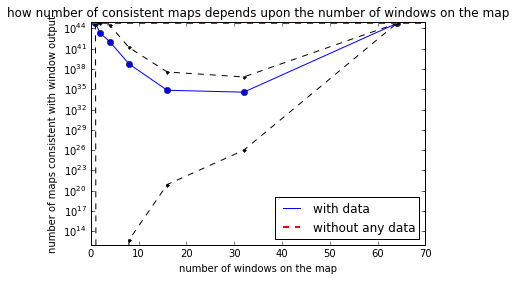

In [127]:
plt.figure()
plt.plot(number_of_windows, cm_mean,'b',label='with data')
plt.plot(number_of_windows, cm_mean,'bo')
plt.plot(number_of_windows, cm_min,'k--')
plt.plot(number_of_windows, cm_min,'k.')
plt.plot(number_of_windows, cm_max,'k--')
plt.plot(number_of_windows, cm_max,'k.')
plt.axhline(y=total_maps,hold=True,lw=2,color='r', linestyle='--',label='without any data')
# plt.fill_between(number_of_windows, cm_max.reshape(number_of_windows.shape), cm_min.reshape(number_of_windows.shape))
plt.yscale('log')
plt.title('how number of consistent maps depends upon the number of windows on the map')
plt.legend(loc='lower right')
plt.xlabel('number of windows on the map')
plt.ylabel('number of maps consistent with window output')

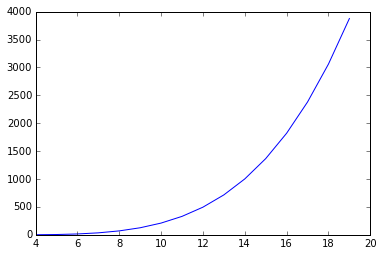

In [129]:
plt.plot(range(4,20), map(lambda x: comb(x,4), range(4,20)))

Count average number of consistent maps for various number of windows / neighborhood sizes.

In [9]:
def nbds_generator(number_of_windows,nbd_size):
    list_of_windows = np.arange(0,number_of_windows)
    nbds = []
    for w in list_of_windows:
        nbds += [tuple(np.sort(list_of_windows[np.argsort(np.abs(w-list_of_windows))[0:nbd_size]]))]
    
    return nbds

In [79]:
def consistent_maps_overlapping_windows(number_of_objects, window_size, window_color_counts,nbds,scaling_term=1.0):
    cnt = 0
    e_comb = lambda n,j: comb(n,j,exact=True)
    for k in range(0,number_of_objects):
        uncounted_colors = e_comb(number_of_objects,k)*(-1)**k
        map_prod = 1
        for target,target_nbd in enumerate(nbds):
            nbd_colorings = [window_color_counts[ij] for ij in target_nbd]
            nbd_powerset,color_count_powerset = cntmch.nbd_color_counts(cntmch.window(target_nbd),nbd_colorings)
            
            counter = cntmch.consistent_map_counter(target, nbd_powerset)
            num_consistent_maps = counter.count_consistent_maps(number_of_objects-k,
                                                               color_count_powerset,
                                                               window_size)
            print "k: %d, target: %d, num: %d" %(k,target, num_consistent_maps)
            map_prod *= num_consistent_maps
        
         
        cnt += uncounted_colors*map_prod
    return cnt

In [11]:
pdb on

Automatic pdb calling has been turned ON


In [22]:
number_of_objects_in_map = 4
largest_number_of_windows = 6
total_number_of_pixels = 2**largest_number_of_windows
number_of_windows = int(total_number_of_pixels / 4.)
size_of_windows = total_number_of_pixels/number_of_windows
nbd_sizes = range(1,9, 1)
samples_per_nbd_size = 1000
print 'number of pixels: %d' %(total_number_of_pixels)
print number_of_windows
print nbd_sizes
print 'size of windows %f' %(size_of_windows)

number of pixels: 64
16
[1, 2, 3, 4, 5, 6, 7, 8]
size of windows 4.000000


In [48]:
cm_median = np.zeros((len(nbd_sizes),1))
cm_max = np.zeros((len(nbd_sizes),1))
cm_min = np.zeros((len(nbd_sizes),1))
indie_cm_median = np.zeros((len(nbd_sizes),1))
cnt = 0


In [49]:
for ns in nbd_sizes: 
    print 'nbd size: %d' %(ns)
    ##just regenerate every time, doesn't take long
    all_colorings=cntmch.generate_window_colorings(number_of_objects_in_map,
                                                   number_of_windows,
                                                   bits=True) 
    ##this will store results
    cm = np.zeros((samples_per_nbd_size,1))
    indie_cm = np.zeros((samples_per_nbd_size,1))
    ##list of tuples splitting up all windows into nbds
    nbds = nbds_generator(number_of_windows,ns)
    
    for spn in range(samples_per_nbd_size):
#         print 'sample: %d' %(spn)
        run_for = np.random.randint(10000,50000)
        try:
            _ = [all_colorings.next() for dummy in range(run_for)]  ##<<randomize selection
        except:
            cc = _
            all_colorings=cntmch.generate_window_colorings(number_of_objects_in_map,
                                                           number_of_windows,
                                                           bits=True)
            print 'reached end of colorings, regenerated'

        cc = all_colorings.next()
        bitcc = map(lambda x: cc[x].count(1), range(len(cc)))
        cm[spn] = consistent_maps_overlapping_windows(number_of_objects_in_map,
                                                      size_of_windows,
                                                      cc,  ##<<passing colorings,not counts
                                                      nbds,
                                                      scaling_term=1.0)
        indie_cm[spn] = maps_consistent_with_data(number_of_objects_in_map,
                                                  size_of_windows*np.ones((number_of_windows,1)),
                                                  bitcc)
        if cm[spn] < 0:
            1/0
        if indie_cm[spn] < 0:
            1/0
    cm_median[cnt] = np.median(cm)
    indie_cm_median[cnt] = np.median(indie_cm)
    cm_max[cnt] = cm.max()
    cm_min[cnt] = cm.min()
    cnt += 1
total_maps = snk(total_number_of_pixels, number_of_objects_in_map)*bang(number_of_objects_in_map)

nbd size: 1
nbd size: 2
nbd size: 3


ZeroDivisionError: integer division or modulo by zero

> <ipython-input-49-fa5db1e8df59>(36)<module>()
     35         if cm[spn] < 0:
---> 36             1/0
     37         if indie_cm[spn] < 0:

ipdb> cm
array([[  1.00800000e+03],
       [  1.67961600e+06],
       [  1.30636800e+06],
       [  3.07328000e+05],
       [  1.97568000e+05],
       [  1.51200000e+03],
       [  1.18540800e+06],
       [  2.82240000e+04],
       [  1.12896000e+05],
       [  5.64480000e+04],
       [  3.95136000e+05],
       [  8.46720000e+04],
       [  1.12896000e+05],
       [  5.53190400e+06],
       [  8.46720000e+04],
       [  1.51200000e+03],
       [  8.46720000e+04],
       [  1.18540800e+06],
       [  1.58054400e+06],
       [  2.37081600e+06],
       [  3.62880000e+04],
       [  1.45152000e+05],
       [  6.04800000e+03],
       [  5.44320000e+04],
       [  2.19520000e+04],
       [  8.46720000e+04],
       [  7.11244800e+06],
       [  7.62048000e+05],
       [  1.12896000e+05],
       [  8.85104640e+07],
       [  5.26848000e+05],
       [  1

In [52]:
cc = (bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0001'), bitarray('0101'), bitarray('1101'), bitarray('1000'), bitarray('0001'), bitarray('1101'), bitarray('1000'))

In [83]:
cc[9:12]

(bitarray('0001'), bitarray('0101'), bitarray('1101'))

In [82]:
nbds[10]

(9, 10, 11)

In [84]:
nbd_pwrset, c_counts = cntmch.nbd_color_counts(cntmch.window(nbds[10]),cc[9:12])

In [85]:
counter = cntmch.consistent_map_counter(10,nbd_pwrset)

In [92]:
print counter.count_consistent_coloring(4,c_counts)
print counter.count_consistent_maps(3,c_counts,4.)

2.0
28.0


In [95]:
dict(zip(nbd_pwrset.tups,c_counts))

{(9,): 1L,
 (9, 10): 2L,
 (9, 10, 11): 3L,
 (9, 11): 3L,
 (10,): 2L,
 (10, 11): 3L,
 (11,): 3L}

In [97]:
for _ in cntmch.generate_window_colorings(2,3):
    print _

('01', '01', '01')
('01', '01', '10')
('01', '01', '11')
('01', '10', '01')
('01', '10', '10')
('01', '10', '11')
('01', '11', '01')
('01', '11', '10')
('01', '11', '11')
('10', '01', '01')
('10', '01', '10')
('10', '01', '11')
('10', '10', '01')
('10', '10', '10')
('10', '10', '11')
('10', '11', '01')
('10', '11', '10')
('10', '11', '11')
('11', '01', '01')
('11', '01', '10')
('11', '01', '11')
('11', '10', '01')
('11', '10', '10')
('11', '10', '11')
('11', '11', '01')
('11', '11', '10')
('11', '11', '11')


In [80]:
consistent_maps_overlapping_windows(number_of_objects_in_map,
                                                      size_of_windows,
                                                      cc,  ##<<passing colorings,not counts
                                                      nbds,
                                                      scaling_term=1.0)

k: 0, target: 0, num: 1
k: 0, target: 1, num: 1
k: 0, target: 2, num: 1
k: 0, target: 3, num: 1
k: 0, target: 4, num: 1
k: 0, target: 5, num: 1
k: 0, target: 6, num: 1
k: 0, target: 7, num: 1
k: 0, target: 8, num: 1
k: 0, target: 9, num: 1
k: 0, target: 10, num: 28
k: 0, target: 11, num: 36
k: 0, target: 12, num: 2
k: 0, target: 13, num: 2
k: 0, target: 14, num: 72
k: 0, target: 15, num: 2
k: 1, target: 0, num: 1
k: 1, target: 1, num: 1
k: 1, target: 2, num: 1
k: 1, target: 3, num: 1
k: 1, target: 4, num: 1
k: 1, target: 5, num: 1
k: 1, target: 6, num: 1
k: 1, target: 7, num: 1
k: 1, target: 8, num: 1
k: 1, target: 9, num: 1
k: 1, target: 10, num: 28
k: 1, target: 11, num: 36
k: 1, target: 12, num: 2
k: 1, target: 13, num: 2
k: 1, target: 14, num: 36
k: 1, target: 15, num: 2
k: 2, target: 0, num: 1
k: 2, target: 1, num: 1
k: 2, target: 2, num: 1
k: 2, target: 3, num: 1
k: 2, target: 4, num: 1
k: 2, target: 5, num: 1
k: 2, target: 6, num: 1
k: 2, target: 7, num: 1
k: 2, target: 8, num: 

-580608.0

In [ ]:
counter = cntmch.consistent_map_counter()

In [75]:
for target,target_nbd in enumerate(nbds):
    nbd_colorings = [cc[ij] for ij in target_nbd]
    nbd_powerset,color_count_powerset = cntmch.nbd_color_counts(cntmch.window(target_nbd),nbd_colorings)
    print color_count_powerset

[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L]
[2L, 2L, 1L, 2L, 1L, 1L, 2L]
[3L, 3L, 1L, 2L, 2L, 3L, 3L]
[3L, 3L, 2L, 3L, 3L, 1L, 3L]
[2L, 3L, 3L, 1L, 1L, 3L, 3L]
[3L, 2L, 3L, 3L, 1L, 1L, 3L]
[1L, 3L, 2L, 3L, 1L, 3L, 3L]
[1L, 3L, 2L, 3L, 1L, 3L, 3L]


In [73]:
4*290304 - 580608

580608

In [57]:
nbds

[(0, 1, 2),
 (0, 1, 2),
 (1, 2, 3),
 (2, 3, 4),
 (3, 4, 5),
 (4, 5, 6),
 (5, 6, 7),
 (6, 7, 8),
 (7, 8, 9),
 (8, 9, 10),
 (9, 10, 11),
 (10, 11, 12),
 (11, 12, 13),
 (12, 13, 14),
 (13, 14, 15),
 (13, 14, 15)]

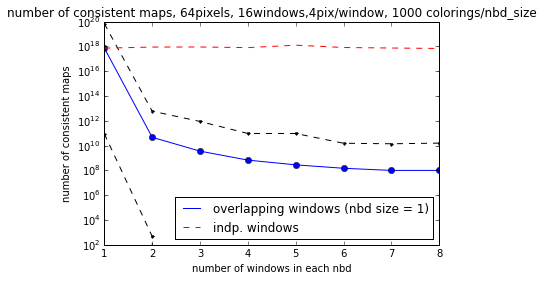

In [28]:
plt.figure()
plt.plot(nbd_sizes, cm_mean,'b',label='overlapping windows (nbd size = 1)')
plt.plot(nbd_sizes, cm_mean,'bo')
plt.plot(nbd_sizes, cm_min,'k--')
plt.plot(nbd_sizes, cm_min,'k.')
plt.plot(nbd_sizes, cm_max,'k--')
plt.plot(nbd_sizes, cm_max,'k.')
plt.plot(nbd_sizes, indie_cm_mean, 'r--', label= 'indp. windows')
plt.yscale('log')
plt.title('number of consistent maps, 64pixels, 16windows,4pix/window, 1000 colorings/nbd_size')
plt.legend(loc='lower right')
plt.xlabel('number of windows in each nbd')
plt.ylabel('number of consistent maps')

In [44]:
indie_cm

array([  9.21773261e+09])

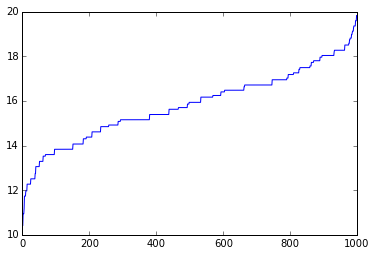

In [45]:
plt.plot(np.log10(np.abs(np.sort(indie_cm,axis=0))))

In [38]:
all_colorings = cntmch.generate_window_colorings(5,16,bits=True)

In [53]:
for cc in range(1000000):
    all_colorings.next()
cc = all_colorings.next()
nbds = nbds_generator(16,1)
ncm = consistent_maps_overlapping_windows(5,4,cc,nbds,scaling_term=1.0)
print ncm
print 'order: %d' %(np.log10(ncm))

0.0


TypeError: %d format: a number is required, not numpy.float64

> <ipython-input-53-5342ff67159d>(7)<module>()
      5 ncm = consistent_maps_overlapping_windows(5,4,cc,nbds,scaling_term=1.0)
      6 print ncm
----> 7 print 'order: %d' %(np.log10(ncm))

ipdb> q


In [17]:
def iter_sample_fast(iterable, samplesize):
    results = []
    iterator = iter(iterable)
    # Fill in the first samplesize elements:
    try:
        for _ in xrange(samplesize):
            results.append(iterator.next())
    except StopIteration:
        raise ValueError("Sample larger than population.")
    random.shuffle(results)  # Randomize their positions
    for i, v in enumerate(iterator, samplesize):
        r = random.randint(0, i)
        if r < samplesize:
            results[r] = v  # at a decreasing rate, replace random items
    return results

In [66]:
florg = list(cc)

In [74]:

florg[-2] = bitarray('11101')
florg[0] = bitarray('11111')

In [88]:
bitcc = map(lambda x: cc[x].count(1), range(len(cc)))
mcd = maps_consistent_with_data(5,5*np.ones((16,1)),bitcc)
print mcd
# print 'order: %d' %(np.log10(mcd))

5.0625e+19


In [105]:
(2**4-1)**8

2562890625